# Cvičení 3: Modelování procesu vedení tepla
Uvažujme oblast tvaru obdélníku o stranách $a \times b$. 

V počátečním
čase $t=0$ má každý bod oblasti určitou teplotu. Úkolem tohoto cvičení
je modelovat průběh vedení tepla v čase, tedy spočítat teplotu v oblasti
v časových krocích $t=dt$, $t=2dt$, $\ldots$, $t=Ndt$. Teplotu budeme reprezentovat pomocí funkce
$u:\mathbb{R}^{3}\rightarrow\mathbb{R}$,
hodnota $u\left(x,y,t\right)$ udává teplotu v bodě o souřadnicích
$\left(x,y\right)$ v čase $t$. 

Nejprve provedeme tzv. diskretizaci - zadanou oblast rozdělíme na
shodné obdélníkové podoblasti o stranách $dx \times dy$.
Teplotu v každé podoblasti budeme reprezentovat pomocí hodnoty teploty ve středu této podoblasti.

Aby bylo zadání kompletní, je potřeba specifikovat tzv. okrajové podmínky.
Budeme předpokládat, že teplota v podoblastech ležících na okraji
oblasti zůstává stále stejná.

## 1. Homogenní materiál
Předpokládejme nejprve, že materiálové parametry $\lambda$ (součinitel tepelné vodivosti), $\rho$ (hustota), $c$ (měrná tepelná kapacita) jsou konstantní v celé oblasti.

Umíme vyjádřit teplotu podoblasti se středem $(x,y)$ v čase $t+dt$ pomocí teplot v bodech $\left(x,y\right)$, $\left(x+dx,y\right)$, $\left(x-dx,y\right)$, $\left(x,y+dy\right)$ a $\left(x,y-dx\right)$ v čase $t$:
$$
u\left(x,y,t+dt\right)\approx u\left(x,y,t\right)+\frac{\lambda}{\rho c}dt\left(\frac{u\left(x-dx,y,t\right)-u\left(x,y,t\right)}{dx^{2}}\right.+
$$
$$
\frac{u\left(x,y+dy,t\right)-u\left(x,y,t\right)}{dy^{2}}+\frac{u\left(x+dx,y,t\right)-u\left(x,y,t\right)}{dx^{2}}+\left.\frac{u\left(x,y+dy,t\right)-u\left(x,y,t\right)}{dy^{2}}\right).
$$

Odvození lze najít v doprovodném textu k počítačovým cvičením.

In [1]:
import matplotlib.pyplot as plt # knihovna pro vykreslování grafů
import numpy as np # matematická knihovna
from numba import jit # just-in-time compiler pro Python

Začneme zadefinováním vstupních parametrů:

In [2]:
dx = 0.01 # délka intervalu diskretizace ve vodorovném směru
dy = 0.01 # délka intervalu diskretizace ve svislém směru
dt = 1.0 # velikost časového kroku
N = 120 # počet časových kroků
lam = 80 # součinitel tepelné vodivosti
rho_c = 8000*450 # hustota x měrná tepelná kapacita

Vytvoříme matici teplot v počátečním čase:

In [3]:
nx = 80 # počet intervalů diskretizace ve vodorovném směru
ny = 60 # počet intervalů diskretizace ve svislém směru
# Oblast reprezentujeme pomocí matice: ny ... počet řádků, nx ... počet sloupců,
# prvky matice tedy budeme indexovat v pořadí y,x.
U_initial = 20*np.ones((ny,nx)) # Počáteční teplotu nastavíme na 20 stupňů.
U_initial[2:32,30:60] = 70 # Do oblasti "vložíme" čtverec o vyšší teplotě
U_initial[35:50,15:30] = 2 # a čtverec o nižší teplotě.

Vykreslíme počáteční teplotu pomocí příkazu imshow:

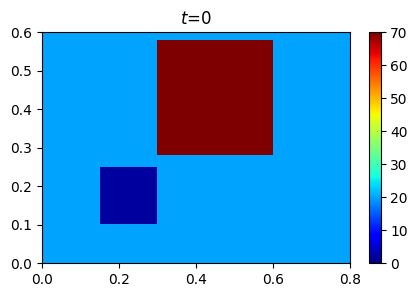

In [4]:
fig, ax = plt.subplots(figsize=(5,3))
cmap = "jet" # výběr barevné škály, vyzkoušejte také "hot" nebo "plasma"
# Další barevné škály najdete na https://matplotlib.org/stable/tutorials/colors/colormaps.html
# Parametry vmin a vmax udávají rozmezí, na které bude barevná škála namapovaná.
vmin = 0 
vmax = 70
extent=(0,nx*dx,0,ny*dy) # skutečné rozměry oblasti
image_initial = ax.imshow(U_initial, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.colorbar(image_initial) # zobrazí barevnou škálu na pravé straně
plt.title("$t$=0")
plt.show()

Následuje nejdůležitější část kódu - jednotlivé časové kroky, v nichž je postupně modelován proces vedení tepla:

In [5]:
@jit(nopython=True) # zrychlí následující funkci (zakomentujte a porovnejte čas výpočtu)
def one_time_step(U0, nx, ny, dx, dy, dt, lam, rho_c):
    U1 = U0.copy() # Teplotu v novém časovém kroce nastavíme na předchozí hodnoty.
    # Projdeme všechny vnitřní prvky matice U1. Vynecháváme okraj, tam je udržována neměnná teplota.
    for x in range(1,nx-1):
        for y in range(1,ny-1):
            # Teplotu v bodě (x,y) upravíme na základě hodnot v sousedních
            # čtyřech bodech. Výsledek zaznamenáme do matice pro nový časový krok.
            u = U0[y,x] # teplota v bodě (x,y) v předchozím časovém kroce
            U1[y,x] += lam/rho_c*dt*(U0[y,x-1]-u)/(dx**2)
            U1[y,x] += lam/rho_c*dt*(U0[y,x+1]-u)/(dx**2)
            U1[y,x] += lam/rho_c*dt*(U0[y-1,x]-u)/(dy**2)
            U1[y,x] += lam/rho_c*dt*(U0[y+1,x]-u)/(dy**2)
    return U1

A nyní provedeme časové kroky v cyklu:

In [6]:
U0 = U_initial.copy() # počáteční teplota
for i in range(N): # cyklus přes časové kroky
    U0 = one_time_step(U0, nx, ny, dx, dy, dt, lam, rho_c)

Nyní již známe aproximaci teploty v čase `N*dt`, vykreslíme ji opět pomocí příkazu imshow:

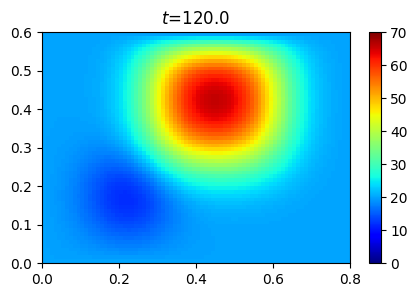

In [7]:
fig, ax = plt.subplots(figsize=(5,3))
image_end = ax.imshow(U0, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.colorbar(image_end) # zobrazí barevnou škálu na pravé straně
plt.title("$t$=" + str(N*dt))
plt.show()

### 1.1. Animace
Grafy rozložení teploty můžeme ukládat v každém časovém kroce (případně vždy po několika krocích). Z výsledných obrázků poté vytvoříme animaci.

In [8]:
%matplotlib inline
from matplotlib import animation

Nastavíme parametry animace a vytvoříme prázdný seznam, do kterého budeme ukládat průběžně vykreslované obrázky. Dále vykreslíme počáteční rozložení teploty a výsledný obrázek rovnou přidáme do seznamu. Jelikož to budeme provádět ještě několikrát, zabalíme vše do funkce pro inicializaci animace:

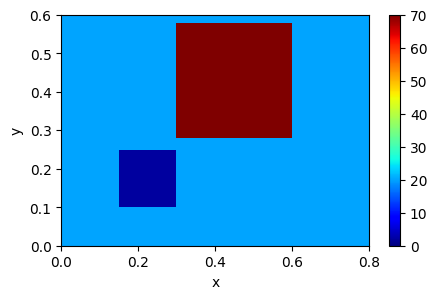

In [9]:
interval_of_saving = 10 # jak často budeme ukládat obrázky/každý kolikátý krok uložíme (grafy rozložení teploty)

def initialize_animation():
    fig, ax = plt.subplots(figsize=(5,3))
    image_initial = ax.imshow(U_initial, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, animated=True)
    plt.colorbar(image_initial)
    plt.xlabel("x")
    plt.ylabel("y")
    txt_title = ax.set_title('')
    return fig, ax, image_initial, txt_title

fig, ax, image_initial, txt_title = initialize_animation()

Pro vykreslování animací potřebujeme funkci které bude provádět časové kroky a vždy po několikátém časovém kroku vytvoří obrázek a uloží pro pozdější video. Tato funkce má specifický tvar, vstupy a výstupy se nyní nezatěžujme, můžeme se více o tvaru funkce dočíst v manuálu k MatPlotLib

In [10]:
def drawframe(*args):
    global U0, nx, ny, dx, dy, dt, lam, rho_c, cmap, vmin, vmax, extent, current_time, interval_of_saving, one_time_step
    for i in range(interval_of_saving):
      U0 = one_time_step(U0, nx, ny, dx, dy, dt, lam, rho_c)
    current_time += interval_of_saving*dt
    image_initial = ax.imshow(U0, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, animated=True)
    txt_title.set_text('Time = {:.1f} s'.format(current_time))
    return image_initial, 

Vyrobíme objekt animace:

In [11]:
current_time = 0
U0 = U_initial.copy()
anim = animation.FuncAnimation(fig, drawframe, frames=10, interval=200, blit=False)

Spustíme animaci a tím i výpočet:

In [12]:
from IPython.display import HTML
HTML(anim.to_html5_video())

## 2. Nehomogenní materiál
V doprovodném textu k počítačovým cvičením najdeme také odvození modelování procesu vedení tepla v oblasti s nehomogenním materiálem. Umíme vyjádřit teplotu podoblasti se středem $(x,y)$ v čase $t+dt$ pomocí teplot v bodech $\left(x,y\right)$, $\left(x+dx,y\right)$, $\left(x-dx,y\right)$, $\left(x,y+dy\right)$ a $\left(x,y-dx\right)$ v čase $t$:
$$u\left(x,y,t+dt\right)\approx u\left(x,y,t\right)+\frac{2}{\rho\left(x,y\right)c\left(x,y\right)}dt\left(\frac{u\left(x-dx,y,t\right)-u\left(x,y,t\right)}{\left(\frac{1}{\lambda\left(x,y\right)}+\frac{1}{\lambda\left(x-dx,y\right)}\right)dx^{2}}\right.+
$$
$$\frac{u\left(x,y+dy,t\right)-u\left(x,y,t\right)}{\left(\frac{1}{\lambda\left(x,y\right)}+\frac{1}{\lambda\left(x,y+dy\right)}\right)dy^{2}}+\frac{u\left(x+dx,y,t\right)-u\left(x,y,t\right)}{\left(\frac{1}{\lambda\left(x,y\right)}+\frac{1}{\lambda\left(x+dx,y\right)}\right)dx^{2}}+\left.\frac{u\left(x,y+dy,t\right)-u\left(x,y,t\right)}{\left(\frac{1}{\lambda\left(x,y\right)}+\frac{1}{\lambda\left(x,y+dy\right)}\right)dy^{2}}\right).
$$
Materiálové parametry nyní musíme zadávat pomocí matic, které odpovídají provedené diskretizaci.

In [13]:
lam = 10*np.ones((ny,nx)) # součinitel tepelné vodivosti (ve formě matice)
rho_c = 8000*450*np.ones((ny,nx)) # hustota x měrná tepelná kapacita (ve formě matice)
# V části oblasti nastavíme jiné materiálové parametry:
lam[17:50,10:70] = 80
rho_c[17:40,10:70] = 9000*450
# Nastavením nekonečné tepelné kapacity docílíme toho, že se teplota této části oblasti nebude měnit:
rho_c[45:55,45:55] = np.inf
U_initial[45:55,45:55] = 70

Vytvoříme novou funkci pro výpočet jednoho časového kroku, která bude zohledňovat nehomogenní materiál (tj. bude pracovat s maticemi LAM a RHO_C).

In [14]:
@jit(nopython=True)
def one_time_step(U0, nx, ny, dx, dy, dt, LAM, RHO_C):
    U1 = U0.copy() # Teplotu v novém časovém kroce nastavíme na předchozí hodnoty.
    # Projdeme všechny vnitřní prvky matice U1. Vynecháváme okraj, tam je udržována neměnná teplota.
    for x in range(1,nx-1):
        for y in range(1,ny-1):
            # Teplotu v bodě (x,y) upravíme na základě hodnot v sousedních
            # čtyřech bodech. Výsledek zaznamenáme do matice pro nový časový krok.
            u = U0[y,x] # teplota v bodě (x,y) v předchozím časovém kroce
            k = 2*dt/RHO_C[y,x] # 2*dt/(rho(x,y)*c(x,y))
            l = 1/LAM[y,x] # 1/lambda(x,y)
            U1[y,x] += k*(U0[y,x-1]-u)/(dx**2)/(l+1/LAM[y,x-1])
            U1[y,x] += k*(U0[y,x+1]-u)/(dx**2)/(l+1/LAM[y,x+1])
            U1[y,x] += k*(U0[y-1,x]-u)/(dy**2)/(l+1/LAM[y-1,x])
            U1[y,x] += k*(U0[y+1,x]-u)/(dy**2)/(l+1/LAM[y+1,x])
    return U1

Pomocí funkce `initialize_animation` nastavíme parametry animace, vytvoříme prázdný seznam pro ukládání obrázků a uložíme do něj počáteční stav.

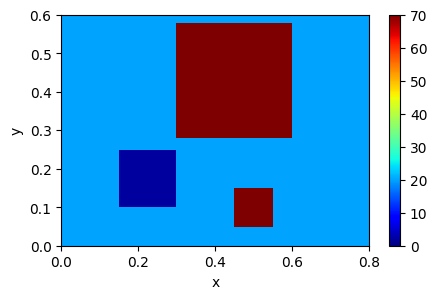

In [15]:
N = 200 # počet časových kroků
interval_of_saving = 10 # jak často budeme ukládat obrázky (grafy rozložení teploty)
fig, ax, image_initial, txt_title = initialize_animation()

Spustíme simulaci a animaci:

In [16]:
current_time = 0
U0 = U_initial.copy()
anim = animation.FuncAnimation(fig, drawframe, frames=int(N/interval_of_saving), interval=200, blit=False)
HTML(anim.to_html5_video())

### 2.1. Připravená modelová úloha - spirála
Ze souborů uložených ve složce **spirala** načteme předem připravené matice `U_initial`, `LAM`, `RHO_C` a `material`. Dále nastavíme základní parametry úlohy.

In [17]:
U_initial = np.load("spirala/U_initial.npy") # počáteční teplota
lam = np.load("spirala/LAM.npy") # součinitel tepelné vodivosti (ve formě matice)
rho_c = np.load("spirala/RHO_C.npy") # hustota x měrná tepelná kapacita (ve formě matice)
material = np.load("spirala/material.npy") # znázornění jednotlivých materiálů

ny,nx = U_initial.shape # počet intervalů diskretizace ve svislém/vodorovném směru
dx = 0.01 # délka intervalu diskretizace ve vodorovném směru
dy = 0.01 # délka intervalu diskretizace ve svislém směru
dt = 0.1 # velikost časového kroku
N = 20000 # počet časových kroků
interval_of_saving = 1000 # jak často budeme ukládat obrázky (grafy rozložení teploty)

vmin = np.min(U_initial)
vmax = np.max(U_initial)
extent=(0,nx*dx,0,ny*dy) # skutečné rozměry oblasti

Pozorně si prohlédněte všechny 3 vstupní matice. Jakým způsobem očekáváte, že bude probíhat vedení tepla? Poslední matice slouží pouze pro znázornění jednotlivých materiálů (spirála = měď, okolí = beton, jeden z okrajů spirály simuluje zdroj tepla).

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1212/904282812.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title("$\lambda(x,y)$")


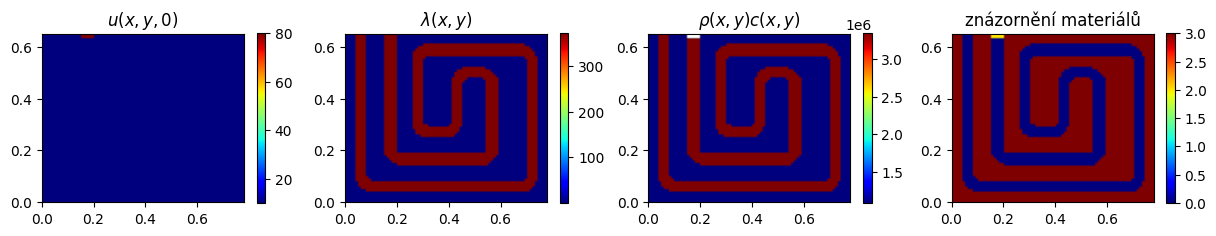

In [18]:
def show_input_matrices():
    fig,ax = plt.subplots(1,4, figsize=(15,2.2))
    im = ax[0].imshow(U_initial,cmap=cmap, extent=extent)
    fig.colorbar(im,ax=ax[0])
    ax[0].set_title("$u(x,y,0)$")
    im = ax[1].imshow(lam,cmap=cmap, extent=extent)
    fig.colorbar(im,ax=ax[1])
    ax[1].set_title("$\lambda(x,y)$")
    im = ax[2].imshow(rho_c,cmap=cmap, extent=extent)
    fig.colorbar(im,ax=ax[2])
    ax[2].set_title("$\\rho(x,y)c(x,y)$")
    im = ax[3].imshow(material,cmap=cmap, extent=extent)
    fig.colorbar(im,ax=ax[3])
    ax[3].set_title("znázornění materiálů")
show_input_matrices()

Provedeme inicializaci animace:

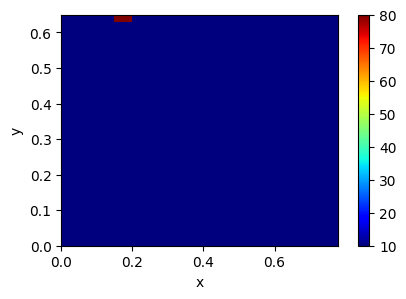

In [19]:
fig, ax, image_initial, txt_title = initialize_animation()

Spustíme výpočet:

In [20]:
current_time = 0
U0 = U_initial.copy()
anim = animation.FuncAnimation(fig, drawframe, frames=int(N/interval_of_saving), interval=200, blit=False)
HTML(anim.to_html5_video())

### 2.2. Připravená modelová úloha - cihlová zeď
Ze souborů uložených ve složce **cihly** načteme předem připravené matice `U_initial`, `LAM`, `RHO_C` a `material`. Dále nastavíme základní parametry úlohy.

In [21]:
U_initial = np.load("cihly/U_initial.npy") # počáteční teplota
lam = np.load("cihly/LAM.npy") # součinitel tepelné vodivosti (ve formě matice)
rho_c = np.load("cihly/RHO_C.npy") # hustota x měrná tepelná kapacita (ve formě matice)
material = np.load("cihly/material.npy") # znázornění jednotlivých materiálů

ny, nx = lam.shape # počet intervalů diskretizace ve svislém/vodorovném směru
dx = 0.005 # délka intervalu diskretizace ve vodorovném směru
dy = 0.005 # délka intervalu diskretizace ve svislém směru
dt = 2.0 # velikost časového kroku
N = 50000 # počet časových kroků
interval_of_saving = 2000 # jak často budeme ukládat obrázky (grafy rozložení teploty)

vmin = np.min(U_initial)
vmax = np.max(U_initial)
extent=(0,nx*dx,0,ny*dy) # skutečné rozměry oblasti

Opět si prohlédneme vstupní matice - oblast reprezentuje průřez cihlovou zdí, na levé straně je nastavena pokojová teplota, na pravé mrzne (opět simulováno pomocí nekonečné tepelné kapacity). Levou část zdi tvoří cihly spojené maltou, pravou část vrstva polystyrenu, oba okraje jsou pokryté omítkou. Rozměry jsou v metrech.

Před spuštěním výpočtu si opět rozmyslete:
* Jak očekáváte, že bude proces vedení tepla probíhat?
* Jaké bude rozložení teplot v oblasti v ustáleném stavu (tj. po uplynutí dlouhé doby)? 

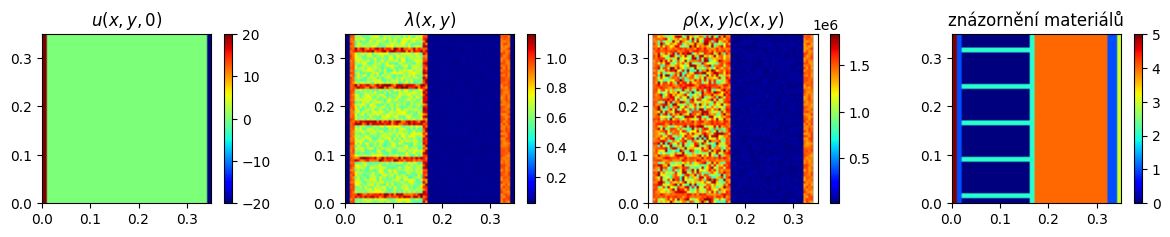

In [22]:
show_input_matrices()

Provedeme inicializaci animace:

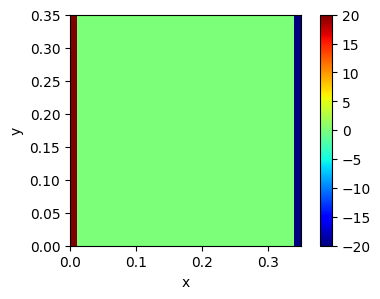

In [23]:
fig, ax, image_initial, txt_title = initialize_animation()

Spustíme výpočet:

In [24]:
current_time = 0
U0 = U_initial.copy()
anim = animation.FuncAnimation(fig, drawframe, frames=int(N/interval_of_saving), interval=200, blit=False)
HTML(anim.to_html5_video())

Pokud by měla simulace modelovat vyrovnávání tepla ve zdi, nedává smysl, že nahoře a dole udržujeme stále stejnou teplotu, tato teplota by se měla také měnit. Proveďme tedy modifikaci funkce `one_time_step`:
* Ve svislém směru (směr $y$) nebudeme vynechávat okraj.
* Jelikož podoblasti na horním okraji nemohou přijmou přírůstek tepla z žádných podoblastí "nad sebou", přírůstek založený na `U0[y+1,x]` přičteme pouze pokud `y<ny-1`. (Použíjeme podmínku `if`.)
* Ze stejného důvodu přírůstek založený na `U0[y-1,x]` přičteme pouze pokud `y>0`.

Tomuto druhu okrajové podmínky se říká Neumannova. Pro doplnění - okrajové podmínce na levé a pravé straně (tj. předepsaná teplota) říkáme Dirichletova.

In [25]:
@jit(nopython=True)
def one_time_step(U0, nx, ny, dx, dy, dt, LAM, RHO_C):
    U1 = U0.copy() # Teplotu v novém časovém kroce nastavíme na předchozí hodnoty.
    # Projdeme všechny vnitřní prvky matice U1.
    for x in range(1,nx-1): # Vynecháváme okraj, tam je udržována neměnná teplota.
        for y in range(0,ny):
            # Teplotu v bodě (x,y) upravíme na základě hodnot v sousedních
            # čtyřech bodech. Výsledek zaznamenáme do matice pro nový časový krok.
            u = U0[y,x] # teplota v bodě (x,y) v předchozím časovém kroce
            k = 2*dt/RHO_C[y,x] # 2*dt/(rho(x,y)*c(x,y))
            l = 1/LAM[y,x] # 1/lambda(x,y)
            U1[y,x] += k*(U0[y,x-1]-u)/(dx**2)/(l+1/LAM[y,x-1])
            U1[y,x] += k*(U0[y,x+1]-u)/(dx**2)/(l+1/LAM[y,x+1])
            if y>0:
                U1[y,x] += k*(U0[y-1,x]-u)/(dy**2)/(l+1/LAM[y-1,x])
            if y<ny-1:
                U1[y,x] += k*(U0[y+1,x]-u)/(dy**2)/(l+1/LAM[y+1,x])
    return U1

Provedeme inicializaci animace:

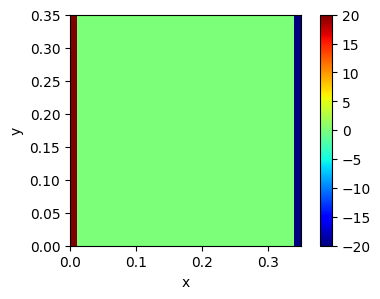

In [26]:
fig, ax, image_initial, txt_title = initialize_animation()

Spustíme výpočet:

In [27]:
current_time = 0
U0 = U_initial.copy()
anim = animation.FuncAnimation(fig, drawframe, frames=int(N/interval_of_saving), interval=200, blit=False)
HTML(anim.to_html5_video())